# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

In [119]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [120]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [121]:
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-15.csv'))

# Data clean

Create response variables, which is visits / population

In [122]:
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']

Log of pm2.5

In [123]:
df['pm25_log'] = np.log1p(df['pm25'])

# EDA

Plotting all diseases in 1 graph is too hard to see anything. Since when one is positive, the others are usually 0. 

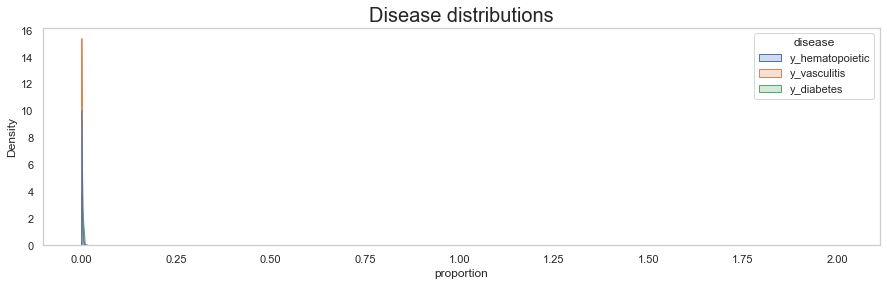

In [124]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

When looking at positive diagnoses, it's still too hard to visualize anything.

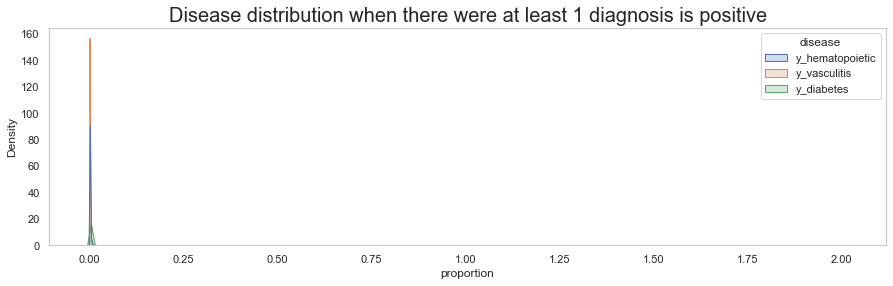

In [125]:
df_melt = pd.melt(df[df['y_hematopoietic'] + df['y_vasculitis'] + df['y_diabetes'] > 0], 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distribution when there were at least 1 diagnosis is positive", size=20)
print('')

Plots of each diagnosis individually, positive observations only, log scaled. 

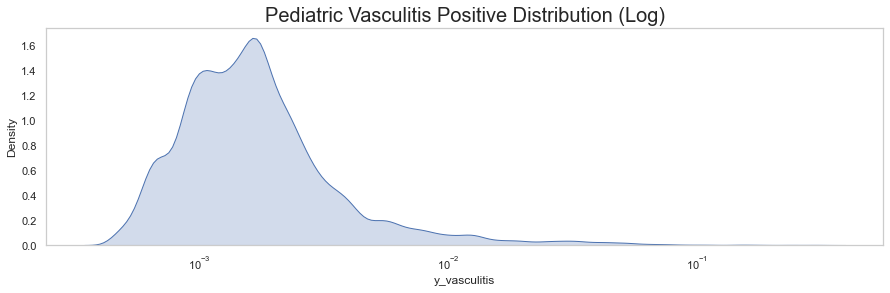

In [126]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Pediatric Vasculitis Positive Distribution (Log)", size=20)
print('')

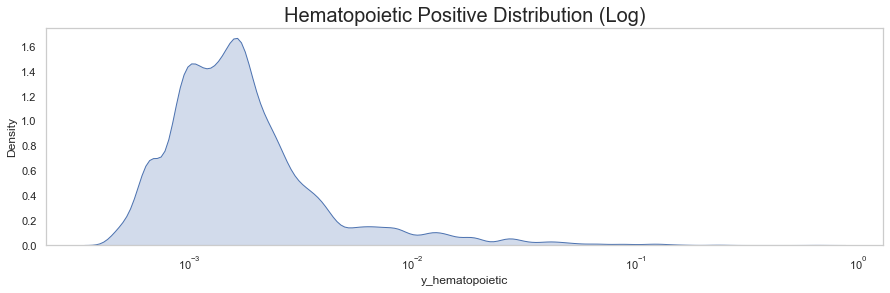

In [127]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

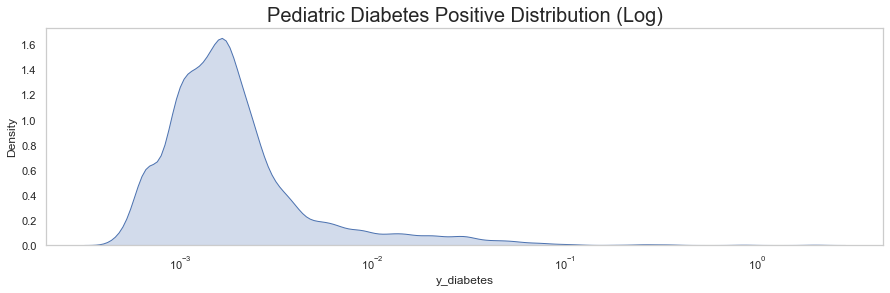

In [128]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Pediatric Diabetes Positive Distribution (Log)", size=20)
print('')

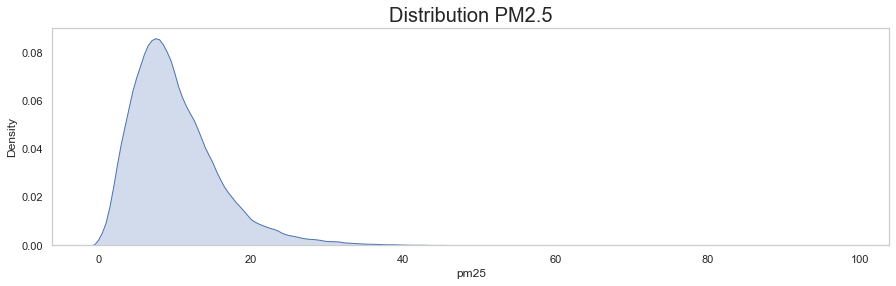

In [129]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True).set_title("Distribution PM2.5", size=20)
print('')

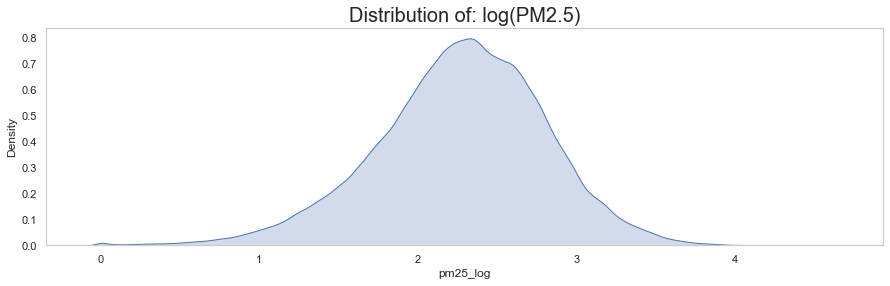

In [130]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25_log", bw_adjust=.8, fill=True)\
  .set_title("Distribution of: log(PM2.5)", size=20)
print('')

Univariate analysis

In [141]:
class FeatureStats:
  
  def __init__(self, df):
    self.df = df


  # method to get linear reg stats from any continuous feature
  def num_var_analyze(self, var, yvar='pm25'):
  
    df1 = self.df[[var, yvar]]
    
    # % missing
    percent_missing = df1[var].isna().sum() / df1.shape[0]
    
    # median impute
    df1[var] = df1[var].fillna(df1[var].median())
    
    # get lm metrics
    lm_model = LinearRegression() 
    lm_model.fit(X = df1[[var]], y=df1[yvar])
    yhat = lm_model.predict(df1[[var]])
    beta = lm_model.coef_[0]
    intercept = lm_model.intercept_
    ss_resid = sum((yhat - df1[yvar].values)**2)
    ss_total = sum((df1[yvar].mean() - df1[yvar].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    output = {'var': [var], 'percent_missing': [percent_missing], 'beta': [beta], 'r_squared': [r_squared], 'intercept': [intercept]}
    return output
  
  
  def sort_num_features(self, var_list, yvar='pm25'):
    res_all = {}
    for var in var_list:
      res_i = self.num_var_analyze(var)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'beta', 'r_squared', 'intercept']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values('r_squared', ascending=False)
    
    return df_res
  
  
  def plot_num_features(self, var_list, yvar='pm25', show_missing_percent=False):
    
    ncol=2
    nrow = int(len(var_list) / ncol) + 1
    
    fig, ax = plt.subplots(nrow,ncol, figsize=(10*ncol, 5*nrow))
    
    # sort num features by r-squared
    sorted_features = self.sort_num_features(var_list)
    var_list = sorted_features['var'].to_list()
    
    var_i = 0
    for i in range(nrow):
      for j in range(ncol):
        
        if var_i+1 > len(var_list):
          break 
        
        var = var_list[var_i]
        
        # clean data
        df1 = self.df[[var, yvar]]
        df1[var] = df1[var].fillna(df1[var].median())
        
        # get regression details
        reg_results = self.num_var_analyze(var)
        
        # plot scatter 
        ax[i][j].scatter(df1[var], df1[yvar], alpha=.3, color='#3d7aba') # #f70eaa = lyft color
        
        # plot line
        xseq = np.linspace(df1[var].min(), df1[var].max(), num=100)
        yseq = reg_results['intercept'][0] + reg_results['beta'][0] * xseq
        xseq = xseq[yseq > 0]
        yseq = yseq[yseq > 0]
        ax[i][j].plot(xseq, yseq, color='k', lw=2.5)
        
        # set title
        if show_missing_percent:
          title_text = '{} | % missing: {:.2f} | beta: {:.1f} | $r^2$: {:.4f}'.format(
            var, reg_results['percent_missing'][0], reg_results['beta'][0], reg_results['r_squared'][0])
        else:
          title_text = '{} | beta: {:.1f} | $r^2$: {:.4f}'.format(var, reg_results['beta'][0], reg_results['r_squared'][0])
        
        ax[i][j].title.set_text(title_text)
        
        var_i += 1
    
    return fig.tight_layout()
  
  
  def cat_var_analyze(self, var, yvar='pm25', max_factor_levels = 10):
    
    df1 = self.df[[var, yvar]]
    
    df_plt = df1.copy()
    
    # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
    if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
      # give the intervals better names that start with a number
      res = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
      res_distinct = list(set(res))
      res_distinct.sort()
      res_string = [str(i) for i in res_distinct]
      res_string = [str(i).rjust(2,'0')+'_'+var for i, var in enumerate(res_string)]
      res_mapping = {x:y for x,y in zip(res_distinct, res_string)}
      res2 = [res_mapping[i] for i in res]
      # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
      df_plt[var] = res2
      df1 = df_plt.copy()
    
    df1[var] = df1[var].astype(str)

    def count_missing(var):
      num_na = df1[var].isna().sum()
      num_unknown = df1[var].map(lambda x: bool(re.search('unknown|no_data|missing', x.lower()))).sum()
      total_na = num_na + num_unknown
      
      return total_na
    
    # % missing
    percent_missing = count_missing(var) / df1.shape[0]
    
    # impute missing
    df1[var] = df1[var].fillna('missing')
    
    # one hot encode
    df1 = pd.get_dummies(df1)
    
    # rename columns
    #df1.columns = df1.columns.str.replace("\.*\s+", "_").str.lower()
    
    # run a linear reg
    X = df1.iloc[:,1:]
    X = sm.add_constant(X)
    y = df1[yvar]
    lm_fit = sm.OLS(y, X).fit() 
    lm_summary = lm_fit.summary()
    aic_ = lm_fit.aic
    bic_ = lm_fit.bic
    
    # save results 
    output = {'var': [var], 'percent_missing': [percent_missing], 'aic': [aic_], 'bic': [bic_]}
    return output
    
  
  def sort_cat_features(self, var_list, yvar='pm25', sort_by='aic', verbose=False):
    res_all = {}
    for var in var_list:
      if verbose:
        print(var)
        
      res_i = self.cat_var_analyze(var)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'aic', 'bic']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values(sort_by, ascending=True)
    
    return df_res
  
  
  def plot_cat_features(self, var_list, yvar='pm25', max_factor_levels = 10, verbose=False, show_missing_percent=False):
    
    fig, axes = plt.subplots(len(var_list), 1, figsize=(15, 6 * len(var_list)))
  
    for i, var in enumerate(var_list):
      if verbose:
        print(var)
        
      df_plt = self.df[[yvar, var]]
      # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
      if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
        # give the intervals better names that start with a number
        res = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
        res_distinct = list(set(res))
        res_distinct.sort()
        res_string = [str(i) for i in res_distinct]
        res_string = [str(i).rjust(2,'0')+'_'+var for i, var in enumerate(res_string)]
        res_mapping = {x:y for x,y in zip(res_distinct, res_string)}
        res2 = [res_mapping[i] for i in res]
        # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
        df_plt[var] = res2
        df1 = df_plt.copy()
      
      df_plt = df_plt\
        .groupby(var)\
        .agg(**{'n': (var, 'count'), yvar: (yvar, 'mean')})\
        .reset_index()\
        .sort_values(var)
      
      # get lm stats
      res = self.cat_var_analyze(var)
      
      # plot
      x = np.arange(df_plt.shape[0])
      width=.7
      
      if len(var_list) == 1:
        ax = axes 
      else:
        ax = axes[i]
        
      ax.tick_params('x', labelrotation=-45)
      ax.plot(df_plt[var], df_plt[yvar], color='magenta', linestyle='-', marker='o', label=yvar)
      ax.set_ylabel(f'Mean {yvar}')
      ax_twin = ax.twinx()
      ax_twin.bar(df_plt[var], df_plt['n'], label="Count", color='darkgrey', width=12 / (df_plt.shape[0]*5))
      ax_twin.set_ylabel('Count')
      ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.2)
      ax_twin.set_ylim(ax_twin.get_ylim()[0], ax_twin.get_ylim()[1]*1.2)
      ax.legend(loc='upper left')
      ax_twin.legend(loc='upper right')
      ax.set_zorder(ax_twin.get_zorder() + 1)
      ax.patch.set_visible(False)
      ax.set_ylim(0, df_plt[yvar].max()*1.1)
      
      if show_missing_percent:
        title_t = '{} | AIC: {:.4} | BIC: {:.4} | Percent Missing: {:.0%}'.format(var, res['aic'][0], res['bic'][0], res['percent_missing'][0])
      else:
        title_t = '{} | AIC: {:.4} | BIC: {:.4}'.format(var, res['aic'][0], res['bic'][0])
      
      ax.set_title(title_t)
    
    fig.tight_layout()

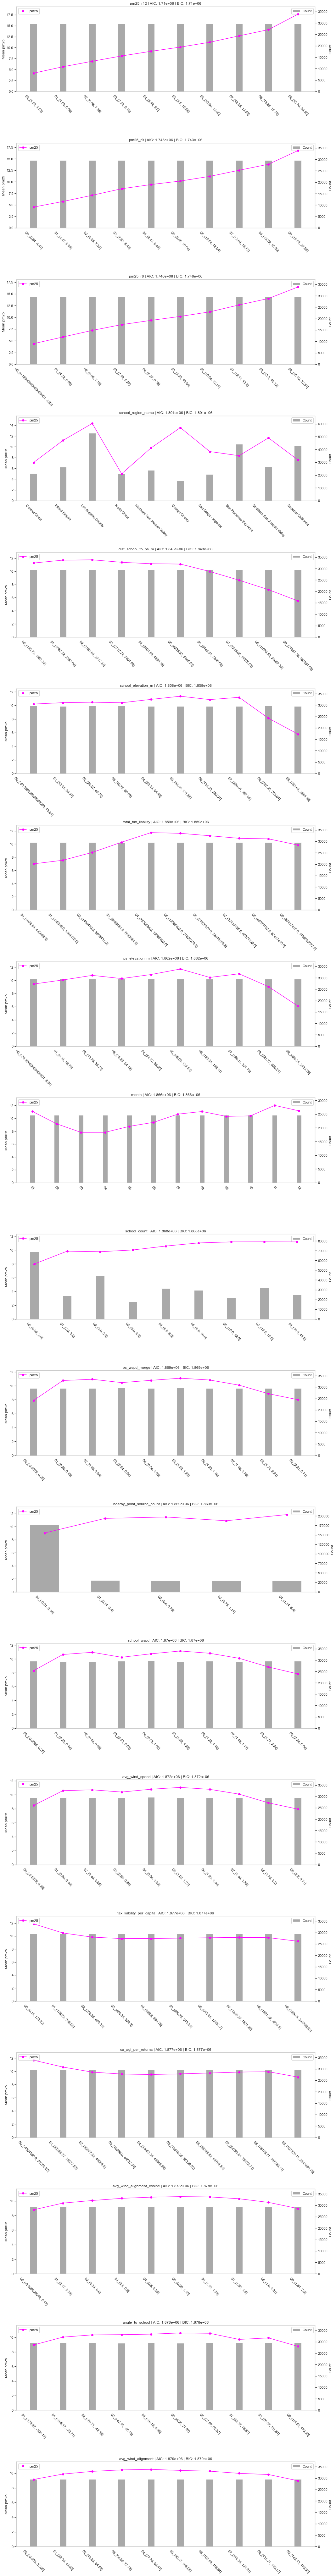

In [145]:
fs = FeatureStats(df[~df['pm25_r12'].isna()])
var_list = [
  'school_region_name', 'month',
  
  'school_wspd', 'school_elevation_m', 'ps_elevation_m', 'dist_school_to_ps_m', 
  'angle_to_school', 'ps_wspd_merge', 'avg_wind_speed', 'avg_wind_alignment', 'avg_wind_alignment_cosine', 
  'nearby_point_source_count', 'ca_agi_per_returns', 'total_tax_liability', 'tax_liability_per_capita', 
  'school_count', 
  
  'pm25_r6', 'pm25_r9', 'pm25_r12']
  
var_list2 = fs.sort_cat_features(var_list)
fs.plot_cat_features(var_list2['var'].to_list(), yvar='pm25', max_factor_levels=10)
print('')

Plots for the log scaled PM2.5 look the same.

# Aim 2 Regression = Predict pm2.5 levels

In [158]:
# select X vars, for the categorical features, select all one hot encoded ones. then drop a baseline for each. 
x_vars = [
  'school_wspd', 'school_elevation_m', 'ps_elevation_m', 'dist_school_to_ps_m', 
  'ps_wspd_merge', 'avg_wind_speed', 'avg_wind_alignment_cosine', 
  'nearby_point_source_count', 'ca_agi_per_returns', 'total_tax_liability', 'tax_liability_per_capita', 
  'school_count', 
  
  'pm25_r6', 'pm25_r9', 'pm25_r12']+\
    [i for i in df.columns if (re.search('month_', i) and i not in 'month_01')]+\
    [i for i in df.columns if (re.search('school_region_name_', i) and i not in 'school_region_name_los_angeles_county')]

df1 = df[~df['pm25_r12'].isna()]

X = df1[x_vars]
y = df1['pm25_log']

# add constant
X = sm.add_constant(X)

# fit
est = sm.OLS(y, X).fit()

# see summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               pm25_log   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                 1.488e+04
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:54:31   Log-Likelihood:                -87694.
No. Observations:              295365   AIC:                         1.755e+05
Df Residuals:                  295330   BIC:                         1.758e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

# Aim 3 Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

In [152]:
help(IV2SLS)

Help on class IV2SLS in module statsmodels.sandbox.regression.gmm:

class IV2SLS(statsmodels.base.model.LikelihoodModel)
 |  IV2SLS(endog, exog, instrument=None)
 |  
 |  Instrumental variables estimation using Two-Stage Least-Squares (2SLS)
 |  
 |  
 |  Parameters
 |  ----------
 |  endog : ndarray
 |     Endogenous variable, 1-dimensional or 2-dimensional array nobs by 1
 |  exog : ndarray
 |     Explanatory variables, 1-dimensional or 2-dimensional array nobs by k
 |  instrument : ndarray
 |     Instruments for explanatory variables. Must contain both exog
 |     variables that are not being instrumented and instruments
 |  
 |  Notes
 |  -----
 |  All variables in exog are instrumented in the calculations. If variables
 |  in exog are not supposed to be instrumented, then these variables
 |  must also to be included in the instrument array.
 |  
 |  Degrees of freedom in the calculation of the standard errors uses
 |  `df_resid = (nobs - k_vars)`.
 |  (This corresponds to the `sma

In [156]:
# select X vars, for the categorical features, select all one hot encoded ones. then drop a baseline for each. 
x_vars = [
  'school_wspd', 'school_elevation_m', 'ps_elevation_m', 'dist_school_to_ps_m', 'ps_wspd_merge', 'avg_wind_speed', 
  'nearby_point_source_count', 'ca_agi_per_returns', 'total_tax_liability', 'tax_liability_per_capita', 
  'school_count', 
  
  'pm25_r6', 'pm25_r9', 'pm25_r12']+\
    [i for i in df.columns if (re.search('month_', i) and i not in 'month_01')]+\
    [i for i in df.columns if (re.search('school_region_name_', i) and i not in 'school_region_name_los_angeles_county')]

df1 = df[~df['pm25_r12'].isna()]

y = df1['pm25_log']
X = df1[x_vars]
X_instruments = df1[x_vars + ['avg_wind_alignment_cosine']]

iv_fit = IV2SLS(
  endog=y,
  exog=X,
  instrument=X_instruments
  ).fit()

print(iv_fit.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               pm25_log   R-squared:                       0.971
Model:                         IV2SLS   Adj. R-squared:                  0.971
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sat, 15 Oct 2022                                         
Time:                        22:48:22                                         
No. Observations:              295365                                         
Df Residuals:                  295331                                         
Df Model:                          34                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/Users/tj/opt/miniconda3/lib/python3.9/site-packages/statsmodels/sandbox/regression/gmm.py:290: RuntimeWarning: invalid value encountered in sqrt
  condno = np.sqrt(eigvals[-1]/eigvals[0])
/Users/tj/opt/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


# Modeling with more complex relationship. 

Now, model $\hat{x}$ using a more complex ML algo such as xgb. Then use that $\hat{x}$ in the 2nd stage least squares regression. 